In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

In [59]:
# Cargar el dataset
!git clone https://github.com/suhasmaddali/Car-Prices-Prediction.git

# Cargar CSV
data = pd.read_csv("Car-Prices-Prediction/Data/data.csv")

print("Dimensiones del dataset:", data.shape)
print("Columnas disponibles:", data.columns)
data.head()

fatal: destination path 'Car-Prices-Prediction' already exists and is not an empty directory.
Dimensiones del dataset: (11914, 16)
Columnas disponibles: Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [60]:
# Seleccionar solo columnas numéricas
X = data.select_dtypes(include=[np.number])

# Manejo de NaN con SimpleImputer (rellena con la media de cada columna)
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

In [61]:
# Definición de los modelos de clustering
modelos_clustering = {
    "KMeans": KMeans(n_clusters=3, random_state=42, n_init=10),
    "AgglomerativeClustering": AgglomerativeClustering(n_clusters=3)
}
dbscan_model = DBSCAN(eps=0.5, min_samples=5)

In [62]:
# Función para clustering y visualización
def realizar_clustering_y_visualizar(X, dataset_name):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reducir a 2D con PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    resultados = {}

    # KMeans y Agglomerative
    for nombre_modelo, modelo in modelos_clustering.items():
        print(f"\n--- Algoritmo: {nombre_modelo} ---")
        clusters = modelo.fit_predict(X_scaled)

        if len(np.unique(clusters)) > 1:
            silhouette = silhouette_score(X_scaled, clusters)
            davies_bouldin = davies_bouldin_score(X_scaled, clusters)
            print(f"Puntuación Silhouette: {silhouette:.2f}")
            print(f"Índice Davies-Bouldin: {davies_bouldin:.2f}")
            resultados[nombre_modelo] = {"silhouette": silhouette, "davies_bouldin": davies_bouldin}
        else:
            print("No se pudieron calcular métricas (solo 1 clúster).")
            resultados[nombre_modelo] = {"silhouette": -1, "davies_bouldin": np.inf}

        # Visualización
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(10, 7))
        cluster_labels = np.unique(clusters)
        for label in cluster_labels:
            points = X_pca[clusters == label]
            ax.scatter(points[:, 0], points[:, 1], s=50, alpha=0.8, label=f'Cluster {label}')
        ax.set_title(f'{nombre_modelo} - {dataset_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel("Componente Principal 1")
        ax.set_ylabel("Componente Principal 2")
        ax.legend()
        plt.show()

    # DBSCAN
    print("\n--- Algoritmo: DBSCAN ---")
    clusters_dbscan = dbscan_model.fit_predict(X_scaled)
    n_clusters_dbscan = len(np.unique(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)

    if n_clusters_dbscan > 1:
        silhouette = silhouette_score(X_scaled, clusters_dbscan)
        davies_bouldin = davies_bouldin_score(X_scaled, clusters_dbscan)
        print(f"Clusters encontrados (sin ruido): {n_clusters_dbscan}")
        print(f"Puntuación Silhouette: {silhouette:.2f}")
        print(f"Índice Davies-Bouldin: {davies_bouldin:.2f}")
        resultados["DBSCAN"] = {"silhouette": silhouette, "davies_bouldin": davies_bouldin}
    else:
        print("DBSCAN no encontró suficientes clústeres.")
        print(f"Clusters encontrados (sin ruido): {n_clusters_dbscan}")
        resultados["DBSCAN"] = {"silhouette": -1, "davies_bouldin": np.inf}

    # Visualización DBSCAN
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    noise_points = X_pca[clusters_dbscan == -1]
    if len(noise_points) > 0:
        ax.scatter(noise_points[:, 0], noise_points[:, 1], c='gray', s=20, label='Ruido', alpha=0.5)
    cluster_labels = np.unique(clusters_dbscan)
    cluster_labels = cluster_labels[cluster_labels != -1]
    for label in cluster_labels:
        points = X_pca[clusters_dbscan == label]
        ax.scatter(points[:, 0], points[:, 1], s=50, alpha=0.8, label=f'Cluster {label}')
    ax.set_title(f'DBSCAN - {dataset_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel("Componente Principal 1")
    ax.set_ylabel("Componente Principal 2")
    ax.legend()
    plt.show()

    # Resumen
    print("\n--- Resumen de Resultados ---")
    mejor_por_silueta = max(resultados, key=lambda k: resultados[k]['silhouette'])
    mejor_por_db = min(resultados, key=lambda k: resultados[k]['davies_bouldin'])
    print(f"Mejor algoritmo (Silhouette): {mejor_por_silueta} ({resultados[mejor_por_silueta]['silhouette']:.2f})")
    print(f"Mejor algoritmo (Davies-Bouldin): {mejor_por_db} ({resultados[mejor_por_db]['davies_bouldin']:.2f})")


--- Algoritmo: KMeans ---
Puntuación Silhouette: 0.26
Índice Davies-Bouldin: 1.36


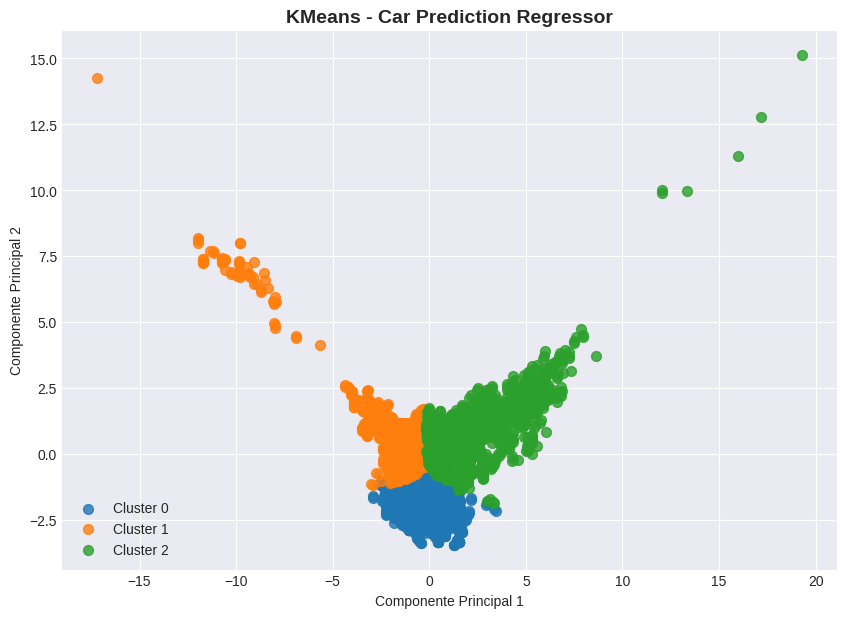


--- Algoritmo: AgglomerativeClustering ---
Puntuación Silhouette: 0.47
Índice Davies-Bouldin: 0.79


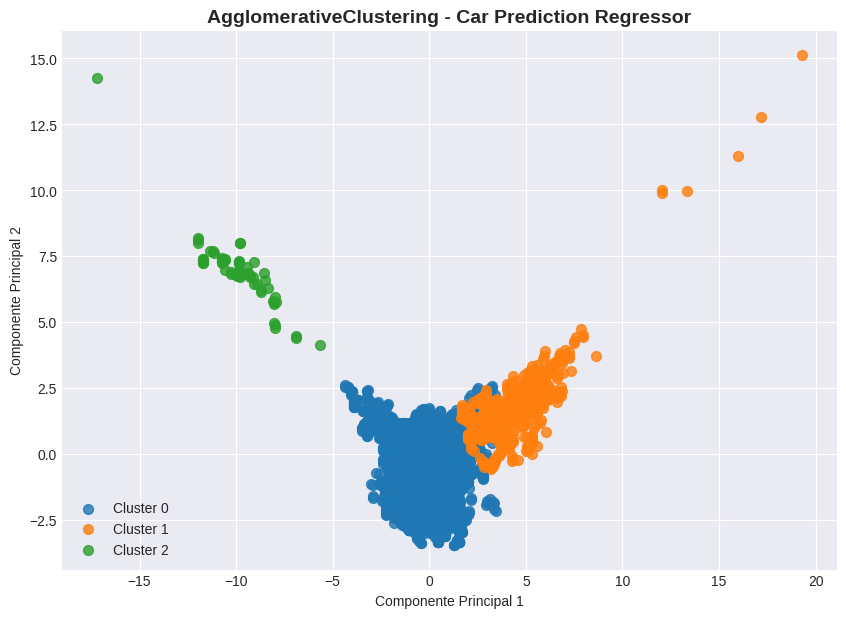


--- Algoritmo: DBSCAN ---
Clusters encontrados (sin ruido): 179
Puntuación Silhouette: -0.10
Índice Davies-Bouldin: 1.58


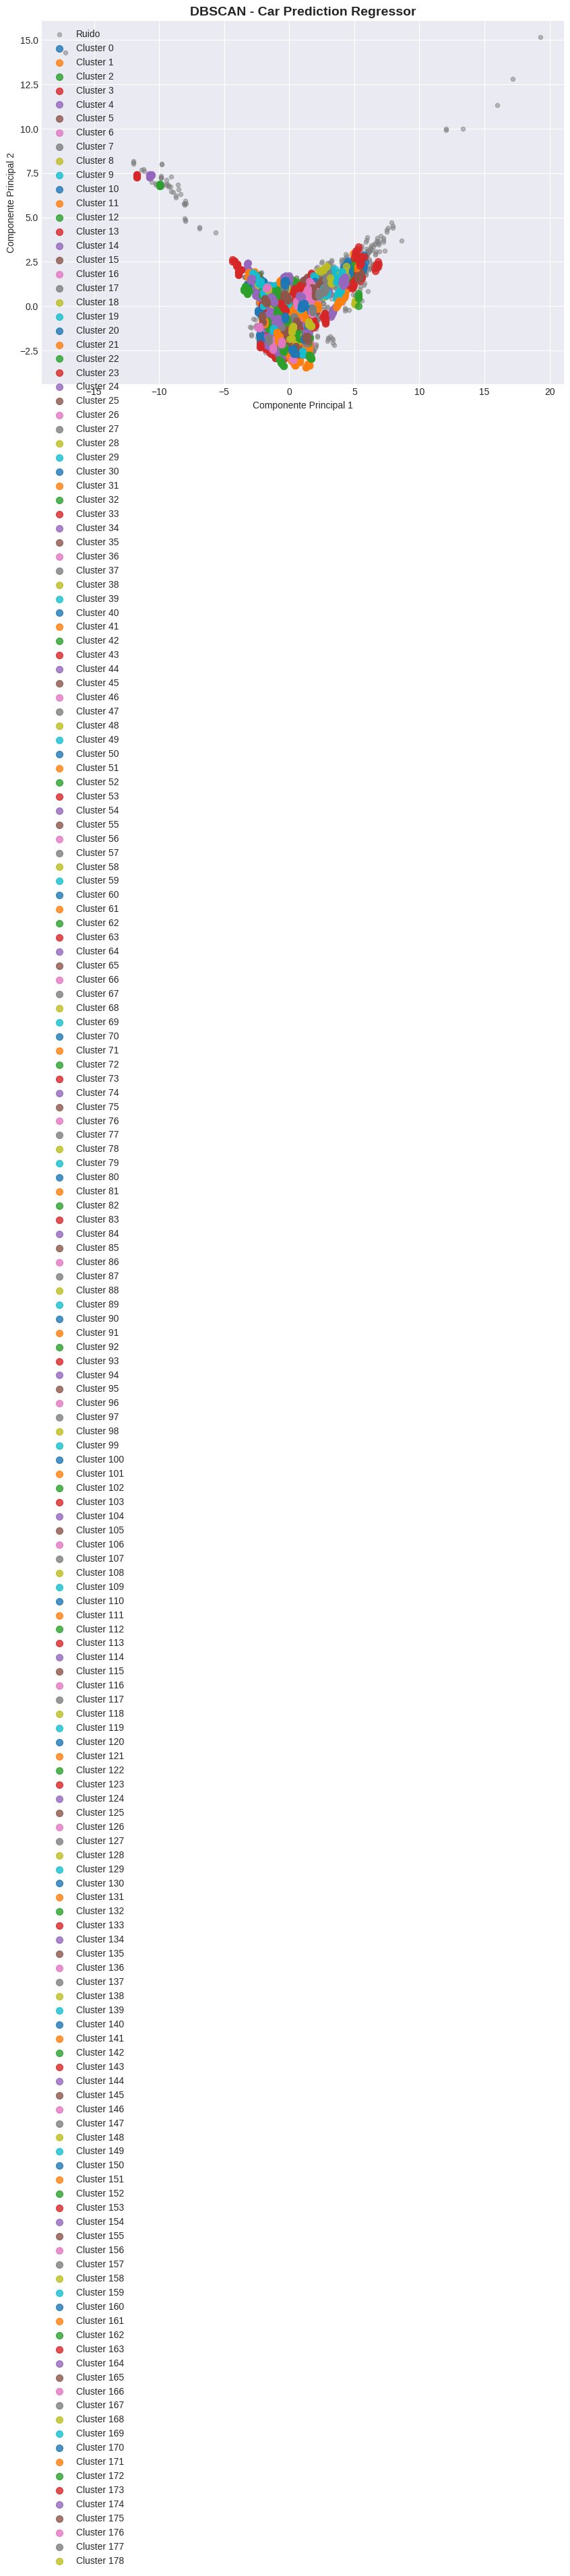


--- Resumen de Resultados ---
Mejor algoritmo (Silhouette): AgglomerativeClustering (0.47)
Mejor algoritmo (Davies-Bouldin): AgglomerativeClustering (0.79)


In [63]:
# Ejecutar clustering sobre el dataset
realizar_clustering_y_visualizar(X, "Car Prediction Regressor")